In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Flatten
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import random
import shutil

In [ ]:
from google.colab import drive
drive.mount("drive")

Mounted at drive


In [ ]:
!unzip drive/MyDrive/Datasets/FINAL_COVID_DATASET.zip
clear_output()

In [ ]:
def split_data(data_path):
  os.mkdir("dataset")
  os.mkdir("dataset/train")
  os.mkdir("dataset/test")
  os.mkdir("dataset/val")
  for i in os.listdir(data_path):
    os.mkdir(f"dataset/train/{i}")
    os.mkdir(f"dataset/test/{i}")
    os.mkdir(f"dataset/val/{i}")
    cat_path = os.path.join(data_path,i)
    filenames = os.listdir(cat_path)
    random.seed(2021)
    random.shuffle(filenames)
    train, test = train_test_split(filenames, test_size=0.25)
    test, val = train_test_split(test, test_size=0.5)
    for file in tqdm(train):
      shutil.copy(f"{cat_path}/{file}", f"dataset/train/{i}/{file}")
    for file in tqdm(test):
      shutil.copy(f"{cat_path}/{file}", f"dataset/test/{i}/{file}")
    for file in tqdm(val):
      shutil.copy(f"{cat_path}/{file}", f"dataset/val/{i}/{file}")

In [ ]:
split_data("FINAL_COVID_DATASET")

100%|██████████| 713/713 [00:00<00:00, 4587.70it/s]


In [ ]:
len(os.listdir("dataset/train/COVID"))

3164

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

generator = ImageDataGenerator(rescale=1./255)
X_train = generator.flow_from_directory(
    "dataset/train",
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

X_test = generator.flow_from_directory(
    "dataset/test",
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

X_val = generator.flow_from_directory(
    "dataset/val",
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)
print("Train:",X_train.class_indices)
print("Test:",X_test.class_indices)
print("Val:",X_val.class_indices)

Found 11094 images belonging to 3 classes.
Found 1849 images belonging to 3 classes.
Found 1850 images belonging to 3 classes.
Train: {'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
Test: {'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
Val: {'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


In [ ]:
base_model = EfficientNetB2(
    input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
    include_top=False,
    weights='imagenet',
)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(3, activation="softmax")(x)

31801344/31790344 [==============================] - 1s 0us/step


In [ ]:
model = Model(inputs=base_model.input, outputs=x)

for layer in model.layers[:50]:
  layer.trainable = False

for layer in model.layers[50:]:
  layer.trainable = True

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_cb = ModelCheckpoint(
    "checkpoint_model.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1,
    mode='min'
)
early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    verbose=1,
    restore_best_weights=True,
    mode='min'
)
reduce_on_plateau_cb = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=2,
    factor=0.5,
    min_lr=1e-6
)

In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit_generator(
      X_train,
      validation_data=X_val,
      epochs=50,
      callbacks=[checkpoint_cb, early_stopping_cb, reduce_on_plateau_cb]
  )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
174/174 [==============================] - ETA: 0s - loss: 0.4536 - accuracy: 0.8012
Epoch 00001: val_loss improved from inf to 1.10541, saving model to checkpoint_model.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


174/174 [==============================] - 231s 1s/step - loss: 0.4536 - accuracy: 0.8012 - val_loss: 1.1054 - val_accuracy: 0.2789 - lr: 0.0010
Epoch 2/50
174/174 [==============================] - ETA: 0s - loss: 0.3244 - accuracy: 0.8588
Epoch 00002: val_loss did not improve from 1.10541
174/174 [==============================] - 198s 1s/step - loss: 0.3244 - accuracy: 0.8588 - val_loss: 1.3010 - val_accuracy: 0.3795 - lr: 0.0010
Epoch 3/50
174/174 [==============================] - ETA: 0s - loss: 0.2710 - accuracy: 0.8845
Epoch 00003: val_loss improved from 1.10541 to 1.09815, saving model to checkpoint_model.h5
174/174 [==============================] - 199s 1s/step - loss: 0.2710 - accuracy: 0.8845 - val_loss: 1.0981 - val_accuracy: 0.3854 - lr: 0.0010
Epoch 4/50
174/174 [==============================] - ETA: 0s - loss: 0.2160 - accuracy: 0.9137
Epoch 00004: val_loss improved from 1.09815 to 0.35258, saving model to checkpoint_model.h5
174/174 [==============================] -

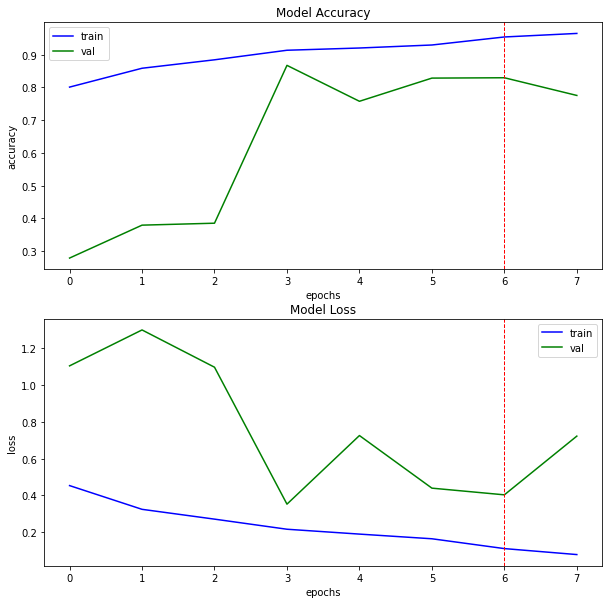

In [ ]:
plt.figure(figsize=(10,10))
for i, met in enumerate(['accuracy', 'loss']):
  plt.subplot(2,1,i+1)
  plt.plot(history.history[met], color="b")
  plt.plot(history.history["val_"+met], color="g")
  plt.title('Model '+met.capitalize())
  plt.xlabel('epochs')
  plt.ylabel(met)
  plt.legend(['train', 'val'])
  plt.axvline(x=6, label=f"line at x = {6}", c='r',ls="--", lw=1)

In [ ]:
model.evaluate(X_test)

29/29 [==============================] - 11s 371ms/step - loss: 0.3834 - accuracy: 0.8637


[0.38337987661361694, 0.8637101054191589]

In [ ]:
cp_model = tf.keras.models.load_model("checkpoint_model.h5")
cp_model.evaluate(X_test)

29/29 [==============================] - 12s 330ms/step - loss: 1.1041 - accuracy: 0.3294


[1.1040652990341187, 0.3293672204017639]

In [ ]:
model.save("model.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
!cp model.h5 drive/MyDrive/Covid-Pneumonia_Detection_Model/Transfer_Learning/efficientnetb2.h5

In [ ]:
import pickle
with open('EfficientNetB2trainHistory', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
# To load history
# history = pickle.load(open('EfficientNetB2trainHistory', "rb"))

In [ ]:
!cp EfficientNetB2trainHistory drive/MyDrive/Covid-Pneumonia_Detection_Model/Transfer_Learning/EfficientNetB2trainHistory